# C12+p scattering


@Author : Young-Ho Song. 

Let us first check energies.

12C 1st excited state energy is 2+ at 4.439 MeV 

13N =12C+p energy levels are 

    13N(g.s.1/2-) S_p =-1.9435  L=1  P1/2   
    (12C+p)(0+)   Ex=1.9435     threshold 
    13N(1/2+)     Ex=2.365      L=0 <= E_p = 0.457
    13N(3/2-)     Ex=3.50       L=1 <=       1.686
    13N(5/2+)     Ex=3.55       L=2 <=       1.734   

momentum scale of bound g.s. BE=1.9435 MeV
sqrt(2mu B) =  58.00548833081094

1st excited state 12C energy  4.439 MeV 
sqrt(2mu E)= 87.6636173420168

Thus, setting high energy scale to 4.4 MeV, we may include up to 5/2+ states.

Since 1/2- channel BE=1.9435 corresponds to momentum gamma=58 MeV, 

Since resonance energies are also similar, we may treat them unnatural case. 

However, in this case, M_hi ~ 90 MeV, M_lo~ 60 MeV
does not have clear separation between short distance and long distance. 
Convergence may be not so great.. 

__Meaning: We may need higher order than LO up to Elab=2 MeV__

Also, $k_C$ is just about 40 MeV. Thus, it also may constraint the convergence.. 

__We may have to apply the theory only at very low energy__

### Import and define constants

In [144]:
import numpy
import numpy as np

import matplotlib.pyplot as plt

import scipy 
import scipy.special
from scipy.special import factorial

from sympy.physics.sho import E_nl
from sympy import symbols
from sympy.physics.sho import R_nl
from sympy import var
from sympy.physics.wigner import wigner_9j
from sympy.physics.wigner import wigner_6j
from sympy.physics.wigner import wigner_3j
from sympy.physics.wigner import clebsch_gordan

from functools import lru_cache

hbarc = 197.326968 # MeV.fm 
amu = 931.4940954 # MeV
mass_p  = 938.272    
mass_n  = 939.5653
mass_N = (mass_p+mass_n)/2.0
alpha = 1.0/137.03599

mass_alpha = 3727.4 # MeV 

fm = 1/hbarc # MeV^-1 

mass_12C= 12*amu # amu or mass_N 
reduced_mass= mass_12C*mass_p/(mass_12C+mass_p)

# Coulomb scale? 
k_C = 6*1*alpha*reduced_mass
print('k_C=',k_C)

# show Fit result with error bar 
def print_fit_summary(p_para,p_cov,L=0):
    """
    print results of curve_fit with error estimation
    """
    dim=len(p_para)
    for i in range(dim):
        print('para[%i] = %e +/- %e'%(i,p_para[i],np.sqrt(abs(p_cov[i,i]))) )
        
    print('*--mass scale--- for L={}*'.format(L))
    for i in range(dim):
        print('scale[%i]= %f'%(i,np.abs(p_para[i])**(1./(2*L+1-2*i)) )    )
    return         

k_C= 37.900090131505706


In [102]:
# p-alpha case
print('p-alpha k_C = ',2*1*alpha*(mass_alpha*mass_p/(mass_alpha+mass_p)))

p-alpha k_C =  10.939964351510294


## Functions related with Coulomb scattering 

  1.  sigma_l(eta) : Coulomb phase shift

  2. C_l(eta) : Coulomb related factor

  3. h_l(eta) : Coulomb related function

  4. f_c(theta,eta) : Coulomb scattering amplitude 



In [103]:
def Coulomb_eta(charge_product,reduced_mass,pcm):
    """
        eta = Z1*Z2*alpha_em*(reduced_mass)/p 
    """
    return charge_product*alpha*(reduced_mass)/pcm 

def Coulomb_phaseshift(L,eta):
    return np.angle(scipy.special.gamma(L+1+1j*eta))

def Coulomb_factor(L,eta):
    """
    Gamow-Sommerfeld factor C_l(eta)**2
    """
    return np.exp(-np.pi*eta)*scipy.special.gamma(L+1+1j*eta)*scipy.special.gamma(L+1-1j*eta)

def Coulomb_h_l(L,eta,pcm):
    """
    h_l(eta)
    
    Note : not well defined numerically at eta =0.
    """
    temp=pcm**(2*L)*Coulomb_factor(L,eta)/Coulomb_factor(0,eta)
    out =temp*(scipy.special.digamma(1j*eta)+1./(2*1j*eta)-np.log(1j*eta))
    return out 

def Coulomb_scattering_amplitude(theta,eta,kcm):
    """
    Coulomb scattering amplitude for spin-less particle
    """
    temp1 = -eta/(2*kcm*np.sin(theta/2.0)**2)
    temp2 = np.exp(-1j*eta*np.log(np.sin(theta/2.0)**2)+2*1j* Coulomb_phaseshift(0,eta)   )
    return temp1*temp2

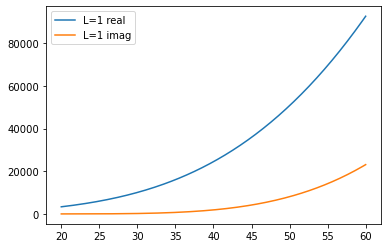

In [104]:
#test 
# h_l(eta,p) should be pure real when p = i p_B 
#
k = 10.0
Coulomb_h_l(1,Coulomb_eta(6,reduced_mass,k),k), Coulomb_h_l(1, Coulomb_eta(6,reduced_mass,1j*k), 1j*k )

k = np.linspace(20.0,60.0,200)
etas = Coulomb_eta(6,reduced_mass,k)

twok_h = 2*k_C*Coulomb_h_l(1,etas,k)
plt.figure()
plt.plot(k,np.real(twok_h),label='L=1 real')
plt.plot(k,np.imag(twok_h),label='L=1 imag')
plt.legend()

## Phase shift and Scattering amplitude

$f_{LSJ}=
\frac{1}{k\cot\delta_{L\frac{1}{2}J}-ik}=\frac{e^{2i\delta}-1}{2ik}
= \frac{k^{2l}C_l(\eta)^2}{k^{2l+1}C_l(\eta)^2(\cot\delta_{L\frac{1}{2}J}-i)+2k_c h_l(\eta)-2k_c h_l(\eta) }
= \frac{k^{2l}C_l(\eta)^2}{-\frac{1}{a_l^{(j)}}+\frac{1}{2}r_l^{(j)} k^2-\frac{1}{4}P_l^{(j)}k^4 +\dots -2k_c h_l(\eta)   }
$

We will use parameters (p0,p1,p2)=(1/a,r,P) in dimension (MeV)^{2l+1}(1,MeV^-2,MeV^-4)

In [105]:
# scattering amplitude 
# in terms of ERE parameters( up to 4 )
def ERE_expansion(k,p0=0,p1=0,p2=0,p3=0):
    """
    -p0+0.5*p1*k**2-0.25*p2*k**4+p3*k**6 
    """
    return -p0+0.5*p1*k**2-p2/4*k**4+p3*k**6


def phase_shift_L(L,ecm,reduced_mass=reduced_mass,ERE_para=None, k_C = k_C, f_L=None ):
    """
    return phaseh shift value in radian 
       and scattering amplitude in MeV^-1. 
    
    ERE_para = (1/a, r, P)
    """
    kcm = np.sqrt(2*reduced_mass*ecm)
    if f_L :
        temp = 1+2*1j*kcm*f_L
    else :
        eta = k_C/kcm ;
        sigma = Coulomb_phaseshift(L,eta)
        hL_eta= Coulomb_h_l(L,eta,kcm)
        Cfactor= kcm**(2*L)*Coulomb_factor(L,eta)
        para = ERE_para ; # pass ERE parameters
        f_L = Cfactor/(ERE_expansion(kcm,para[0],para[1],para[2],para[3])-2*k_C*hL_eta)
        temp = 1+2*1j*kcm*f_L        
    delta_L = np.log(temp)/(2*1j)
    return delta_L, f_L 

## Cross sections 

Although Phase shift is equivalent to cross section, 
let us make it explicit. 

For zero spin particles, the cross section is simple. 

$(\frac{d\sigma}{d\Omega})=|f_c(\theta)+\sum_{L J M}\sqrt{4\pi}\sqrt{2L+1} Y_{L,0}(\theta)e^{2i\sigma_L} f_L(k)|^2$

For non-zero spin, one needs C.-G. coefficients. 

One can obtain cross section from ERE_expansion fits or phase shifts directly. 


In [106]:
def diff_cross(ecm, theta_cm,reduced_mass=reduced_mass,ERE_data=None, k_C = k_C, Lmax = 2, opt_str=1.0 ):
    """
    spinless case only 
    
    ERE_data should contains para for all partial waves considered 
    
    differential cross section in theta_cm(radian) at Ecm 
    in units of fm^2 
    
    ERE_data must be a form of 
    {0: (p0,p1,p2...), 1: (p0,p1,p2...) ... Lmax: (p0,p1,p2..) }
    length of ERE_para is the same as that of phase_shift_L function.. 
    If fewer number of parameters are used, they have to be augmented. 
    """
    sums = 0.0 
    kcm = np.sqrt(2*reduced_mass*ecm); 
    eta = k_C/kcm ;
    if ERE_data:
        for L in range(Lmax+1): 
            sigmaL = Coulomb_phaseshift(L,eta)
            temp = np.sqrt(4*np.pi*(2*L+1))*scipy.special.sph_harm(0,L, 0,theta_cm)*np.exp(2*1j*sigmaL)  
            delta,f_L=phase_shift_L(L,ecm,reduced_mass=reduced_mass,ERE_para=ERE_data[L], k_C = k_C)
            sums = sums +temp*f_L 
    else:
        sums=0.0
    f_C = Coulomb_scattering_amplitude(theta_cm,eta,kcm)
    return np.abs(f_C+opt_str*sums)**2*hbarc**2

For non-zero spin case. include multi-channel information as a dictionary 

In [107]:
def diff_cross_multi_channel(mz, mpz, ecm, theta_cm, reduced_mass=reduced_mass, ERE_data = None, k_C= k_C, Jmax = 2, opt_str =1.0 ):
    """
    General Differential cross section code for ecm and theta_cm 
    For the moment, spinless core + spin 1/2 elastic scattering only. 
    
    return (dSigma/dOmega)_{mpz,mz} in fm^2 units 

    k_C = Coulomb momentum scale , eta= k_C/k_cm 
    Jmax = maximum value of total angular momentum
    opt_str = scale for strong amplitude 
              (full amplitude)= (coulomb scattering amplitude)+(opt_str)*(strong amplitude)
    ERE_data = dictionary of input parameters. 
               channel numbers are 0,1,2,.... 
               channel info are stored as 
               channels : {'L': L-value,'S': S-value,'J': J-value, 'para': parameter tuple }               
    """
    kcm = np.sqrt(2*reduced_mass*ecm); 
    eta = k_C/kcm ;
    
    sums = 0.0 
    if ERE_data:
        for i in ERE_data:
            L=ERE_data[i]['L'];
            S=ERE_data[i]['S'];
            J=ERE_data[i]['J'];
            paras=ERE_data[i]['para'];
            sigmaL = Coulomb_phaseshift(L,eta)
            if J < Jmax: # include channel
                factor = np.sqrt(4*np.pi*(2*L+1))*(scipy.special.sph_harm(mz-mpz,L, 0,theta_cm)
                               *float(clebsch_gordan(L,S,J, 0,mz,mz))
                               *float(clebsch_gordan(L,S,J, mz-mpz,mpz,mz)) )
                if abs(factor) >1.e-24:
                    delta,f_L=phase_shift_L(L,ecm,reduced_mass=reduced_mass,ERE_para=paras, k_C = k_C)
                    sums = sums + factor*np.exp(2*1j*sigmaL)*f_L               
    else:
        sums=0.0
    f_C = Coulomb_scattering_amplitude(theta_cm,eta,kcm)*(mz==mpz)
    return np.abs(f_C+opt_str*sums)**2*hbarc**2  # return fm^2

def unpol_diff_cross_multi_channel(ecm, theta_cm, reduced_mass=reduced_mass, ERE_data = None, k_C= k_C, Jmax = 2, opt_str =1.0 ):
    """
    get unpolarized differential cross section by sum and average over polarization
    only for spin-half +spin-zero scattering
    """
    sig1 = diff_cross_multi_channel(0.5, 0.5, ecm, theta_cm, 
            reduced_mass=reduced_mass, ERE_data = ERE_data, k_C= k_C, Jmax = Jmax, opt_str =opt_str)
    sig2 = diff_cross_multi_channel(0.5, -0.5, ecm, theta_cm, 
            reduced_mass=reduced_mass, ERE_data = ERE_data, k_C= k_C, Jmax = Jmax, opt_str =opt_str)
    sig3 = diff_cross_multi_channel(-0.5, 0.5, ecm, theta_cm, 
            reduced_mass=reduced_mass, ERE_data = ERE_data, k_C= k_C, Jmax = Jmax, opt_str =opt_str)
    sig4 = diff_cross_multi_channel(-0.5, -0.5, ecm, theta_cm, 
            reduced_mass=reduced_mass, ERE_data = ERE_data, k_C= k_C, Jmax = Jmax, opt_str =opt_str)
    return (sig1+sig2+sig3+sig4)/2. # in fm^2 

Compute Differential cross section from phase shift value input 

In [108]:
def dcs_from_phase(mz, mpz, ecm, theta_cm,phase_shifts=None
                   ,reduced_mass=reduced_mass, k_C= k_C, Jmax = 2):
    """
    General Differential cross section code for ecm and theta_cm 
    For the moment, spinless core + spin 1/2 elastic scattering only. 
    
    return (dSigma/dOmega)_{mpz,mz} in fm^2 units 
    
    theta_cm in radian

    k_C = Coulomb momentum scale , eta= k_C/k_cm 
    Jmax = maximum value of total angular momentum
    opt_str = scale for strong amplitude 
              (full amplitude)= (coulomb scattering amplitude)+(opt_str)*(strong amplitude)
    phase shifts = dictionary of input parameters. 
               channel numbers are 0,1,2,.... 
               channel info are stored as 
               channels : {'L': L-value,'S': S-value,'J': J-value, 'para': phase shift degree }               
    """
    kcm = np.sqrt(2*reduced_mass*ecm); 
    eta = k_C/kcm ;
    
    sums = 0.0 
    for i in phase_shifts :
        L=phase_shifts[i]['L'];
        S=phase_shifts[i]['S'];
        J=phase_shifts[i]['J'];
        para=phase_shifts[i]['para'];
        sigmaL = Coulomb_phaseshift(L,eta)
        if J < Jmax: # include channel
                factor = np.sqrt(4*np.pi*(2*L+1))*(scipy.special.sph_harm(mz-mpz,L, 0,theta_cm)
                               *float(clebsch_gordan(L,S,J, 0,mz,mz))
                               *float(clebsch_gordan(L,S,J, mz-mpz,mpz,mz)) )
                if abs(factor) >1.e-24: #when the factor is non-zero 
                    delta = para*np.pi/180. # to radian 
                    f_L = (np.exp(2*1j*delta )-1.0)/(2.0*1j*kcm)
                    sums = sums + factor*np.exp(2*1j*sigmaL)*f_L               
    f_C = Coulomb_scattering_amplitude(theta_cm,eta,kcm)*(mz==mpz) #coulomb scattering for diagonal spin projection
    return np.abs(f_C+sums)**2*hbarc**2  # return fm^2

def unpol_dcs_from_phase(ecm, theta_cm,phase_shifts=None
                   ,reduced_mass=reduced_mass, k_C= k_C, Jmax = 2):
    """
    compute unpolarized differential cross section from given phase shifts
    for 1/2 projectile and 0 target scattering
    """
    sig1 = dcs_from_phase(0.5, 0.5, ecm, theta_cm,phase_shifts=phase_shifts
                   ,reduced_mass=reduced_mass, k_C= k_C, Jmax = Jmax)
    sig2 = dcs_from_phase(0.5, -0.5, ecm, theta_cm,phase_shifts=phase_shifts
                   ,reduced_mass=reduced_mass, k_C= k_C, Jmax = Jmax)
    sig3 = dcs_from_phase(-0.5, 0.5, ecm, theta_cm,phase_shifts=phase_shifts
                   ,reduced_mass=reduced_mass, k_C= k_C, Jmax = Jmax)
    sig4 = dcs_from_phase(-0.5, -0.5, ecm, theta_cm,phase_shifts=phase_shifts
                   ,reduced_mass=reduced_mass, k_C= k_C, Jmax = Jmax)
    return (sig1+sig2+sig3+sig4)/2.0 # in fm^2 

## Momentum scales
Let us see the momentum scale of each resonance and bound state 

$\gamma$ = [ 58.00548833, 28.12774492, 54.02634655, 54.79000769 ] 

for P1/2 bound state, S1/2 , P3/2, D3/2 resonance 

In [109]:
## Momentum scales 

# g.s. P1/2 have B.E.=1.9435
# S1/2 resonance at 0.457 
# P3/2 resonance at 1.686
# D5/2 resonance at 1.734
BE = np.array([ -1.9435, 0.457, 1.686, 1.734 ])

np.sqrt(2*reduced_mass*abs(BE))


array([58.00548833, 28.12774492, 54.02634655, 54.79000769])

## Read experimental data

Note that Here x-axis is E_{lab}
Data is from EXFOR for https://www.nndc.bnl.gov/exfor/servlet/X4sGetSubent?reqx=1721&subID=130125002&plus=1

energies are lab energy, angle is cm angle, differential cross section in cm frame. 

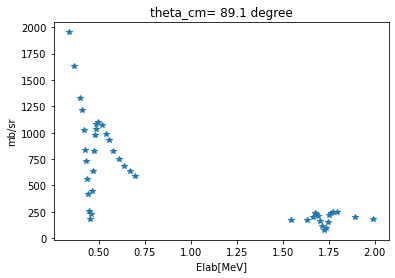

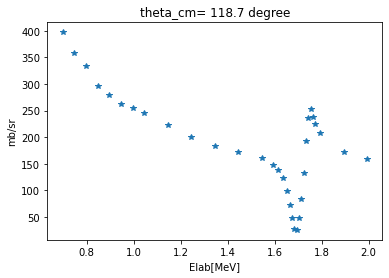

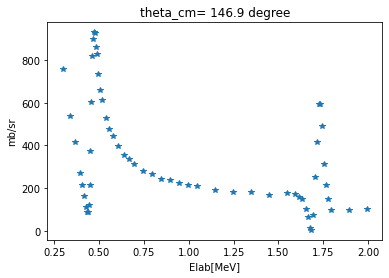

cm angles= [ 89.1 118.7 146.9]
lab angles= [ 84.34314111 114.34575015 144.09910219]


In [110]:
##check
#exp data from EXFOR_H.Meyer_Z.Phys.A279_41_1976
import myutil
data=myutil.read_fresco_res('exp_Meyer76.txt')
# data[0][angle, Elab, ds_cm(mb/sr), err, ratio]
for i in [0,1,2]:
    data[i]=np.array(data[i])
    plt.figure()
    plt.title('theta_cm= %4.1f degree'%(data[i][0,0]))
    plt.plot(data[i][:,1],data[i][:,2],'*' )
    plt.ylabel('mb/sr')
    plt.xlabel('Elab[MeV]')
    plt.show()

# extract unique Elab energies 
energies=[]
for i in data[0][:,1]:
    energies.append(i)
for i in data[1][:,1]:
    energies.append(i)    
for i in data[2][:,1]:
    energies.append(i)   
    
energies=np.array(energies)
energies=np.unique(energies)

# unique angles 
angles =np.array([data[0][0,0], data[1][0,0], data[2][0,0]])
lab_angles = np.arctan(np.sin(angles*np.pi/180.)/( 1./12.+np.cos(angles*np.pi/180.)))*180./np.pi
# make positive
lab_angles = lab_angles*(lab_angles >0.)+(lab_angles+180.0)*(lab_angles<0)
print('cm angles=',angles)
print('lab angles=',lab_angles)

## Phase shift from R-matrix analysis

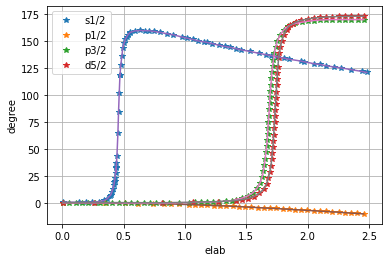

In [111]:
PhaseShift = myutil.read_fresco_res('Azuma_PhaseShift.txt')
names_PhaseShift=['s1/2','p1/2','p3/2','d5/2']
for i in [0,1,2,3]:
    PhaseShift[i]=np.array(PhaseShift[i])
    plt.plot(PhaseShift[i][:,0],PhaseShift[i][:,1],'*',label=names_PhaseShift[i])
    plt.xlabel('Proton energy[MeV]')
    plt.ylabel('degree')
plt.legend()    

# interpolation of  the phase shift as a function of elab
from scipy.interpolate import interp1d
interpf={}
for i in [0,1,2,3]:
    x = PhaseShift[i][:,0]
    y = PhaseShift[i][:,1]
    interpf[i] = interp1d(x,y,fill_value ='extrapolate')
    #plt.plot(x,y,'*',label=names_PhaseShift[i])
    plt.plot(x,interpf[i](x))
    plt.xlabel('elab')
    plt.ylabel('degree')
plt.grid()
plt.legend()


### Cross section from R-matrix phase shift

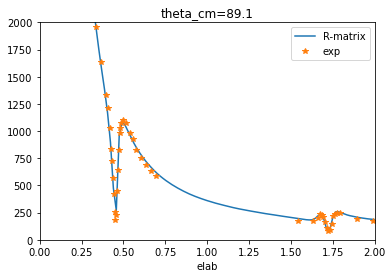

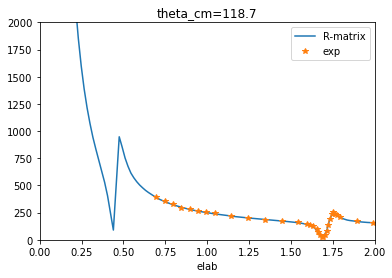

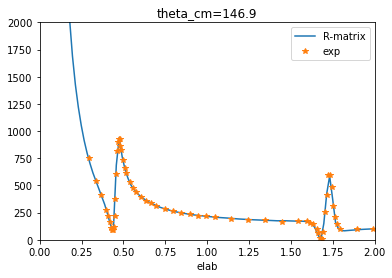

In [112]:
#=======R-matrix Cross section    
ecm = np.linspace(0.1,2.5,150) 
elab= ecm*mass_p/reduced_mass 
phase_shifts_R = {  
    0 : {'L':0,'S':0.5,'J': 0.5, 'para': interpf[0](elab)  },
    1 : {'L':1,'S':0.5,'J': 0.5, 'para': interpf[1](elab)  },
    2 : {'L':1,'S':0.5,'J': 1.5, 'para': interpf[2](elab)  },
    3 : {'L':2,'S':0.5,'J': 2.5, 'para': interpf[3](elab)  }   
} 

for i in [0,1,2]: # angles 
    plt.figure()
    plt.xlabel('elab')
    plt.title('theta_cm={}'.format(angles[i]) )
    theta_cm = angles[i]
    dsigma = unpol_dcs_from_phase(ecm, theta_cm*np.pi/180., phase_shifts=phase_shifts_R, Jmax=3.0)*10
    plt.plot(elab,dsigma,label='R-matrix')
    plt.plot(data[i][:,1],data[i][:,2],'*',label='exp')
    plt.xlim([0,2])
    plt.ylim([0,2000])
    plt.legend()


__this shows that we may treat R-matrix phase shift as a kind of experimental data__

### Denominator of propagator

Fit to the full denominator of propagator.

In terms of phase shift
$$ D_L(E) = k^{2L+1} C_L(\eta)^2 (\cot\delta-i)$$

In terms of ERE parameter
$$ D^{fit}_L(E) = -p_0+\frac{1}{2}p_1 k^2-\frac{1}{4} p_2 k^4+\dots - 2 k_C h_l(\eta) $$

Only consider the real part of $D_L(E)$. 
This function can be defined for negative energy(or complex energy). 

And it should be zero at Re$D_L(E=-E_B)=0$. Or $D_L(E=E_R-i\Gamma_R)=0$.

In [113]:
# Denominator
def fit_DL(Ecm,p0=0.0,p1=0.0,p2=0.0,p3=0.0,L=0):
    """
    Re(D_L^{fit}(E)) in terms of ERE parameters 
    """
    kcm = np.sqrt(2*reduced_mass*Ecm*(1.0+0j))
    eta = k_C/kcm ;
    sigma = Coulomb_phaseshift(L,eta)
    hL_eta= Coulomb_h_l(L,eta,kcm)
    return np.real( ERE_expansion(kcm,p0,p1,p2,p3) -2*k_C*hL_eta)

#---for each L-values 
def fit_DL0(Ecm,p0=0.0,p1=0.0,p2=0.0,p3=0.0,L=0):
    """
    Re(D_L^{fit}(E)) in terms of ERE parameters 
    """
    kcm = np.sqrt(2*reduced_mass*Ecm*(1.0+0j))
    eta = k_C/kcm ;
    sigma = Coulomb_phaseshift(L,eta)
    hL_eta= Coulomb_h_l(L,eta,kcm)
    return np.real( ERE_expansion(kcm,p0,p1,p2,p3) -2*k_C*hL_eta)

def fit_DL1(Ecm,p0=0.0,p1=0.0,p2=0.0,p3=0.0,L=1):
    """
    Re(D_L^{fit}(E)) in terms of ERE parameters 
    """
    kcm = np.sqrt(2*reduced_mass*Ecm*(1.0+0j))
    eta = k_C/kcm ;
    sigma = Coulomb_phaseshift(L,eta)
    hL_eta= Coulomb_h_l(L,eta,kcm)
    return np.real( ERE_expansion(kcm,p0,p1,p2,p3) -2*k_C*hL_eta)

def fit_DL2(Ecm,p0=0.0,p1=0.0,p2=0.0,p3=0.0,L=2):
    """
    Re(D_L^{fit}(E)) in terms of ERE parameters 
    """
    kcm = np.sqrt(2*reduced_mass*Ecm*(1.0+0j))
    eta = k_C/kcm ;
    sigma = Coulomb_phaseshift(L,eta)
    hL_eta= Coulomb_h_l(L,eta,kcm)
    return np.real(  ERE_expansion(kcm,p0,p1,p2,p3) -2*k_C*hL_eta)

def phase_DL(Ecm,delta,L,k_C=k_C):
    """
    Re( D_L(E) ) in terms of phase shift
    """
    kcm = np.sqrt(2*reduced_mass*Ecm*(1.0+0j))
    eta = k_C/kcm ;
    sigma = Coulomb_phaseshift(L,eta)
    hL_eta= Coulomb_h_l(L,eta,kcm)
    temp = kcm**(2*L+1)*Coulomb_factor(L,eta)
    return np.real(temp*(1.0/np.tan(delta)-1j)) 

def positive_phase(phase):
    """
    convert negative phase shift(degree) 
    to positive one by adding 180 degree 
    """
    return (phase < 0)*(phase+180.0)+(phase >=0)*phase

plotting D_L(E) function from R-matrix phase shift


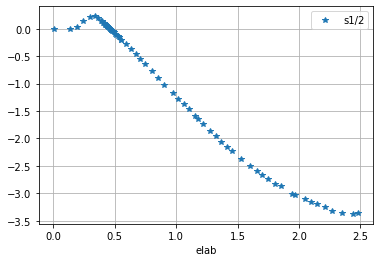

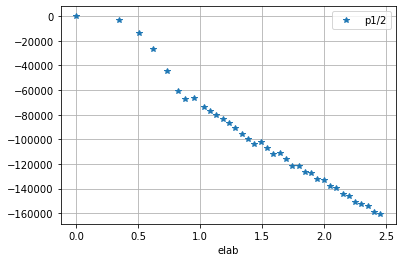

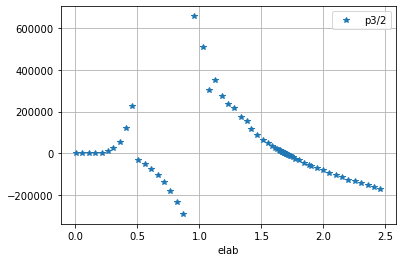

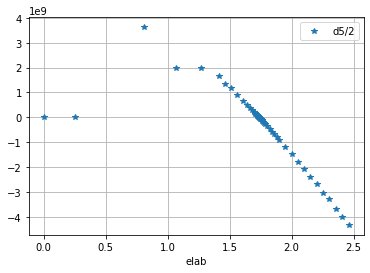

In [114]:
# plot R-matrix phase shift result for S1/2 channel 
# let us not use first few points 
print('plotting D_L(E) function from R-matrix phase shift')
elab_exp={}
ecm_exp={}
kcm_exp={}
ydata={}
# names_PhaseShift=['s1/2','p1/2','p3/2','d5/2']
L_list=[0,1,1,2]
for i in [0,1,2,3]:
    plt.figure()
    elab_exp[i] = PhaseShift[i][:,0] 
    ecm_exp[i] = PhaseShift[i][:,0]*12./13
    kcm_exp[i] = np.sqrt(2*reduced_mass*ecm_exp[i])
    ydata[i] = phase_DL(ecm_exp[i] , PhaseShift[i][:,1]*np.pi/180,L=L_list[i])
    plt.plot(elab_exp[i],ydata[i],'*',label=names_PhaseShift[i])
    plt.xlabel('elab');plt.grid();
    plt.legend()    

It suggests that the phase shift points at small energy is not reliable. 
__One have to ignore values at low energies to fit__

## S1/2 channel phase shift fit with D_L function

from s1/2 D_L plot, let us ignore first 10 points

In [115]:
def plot_fit_DL(exp_id=0,L=0, lower_cut=10,upper_cut=40,p0 = None):
    print('Elab_low=',elab_exp[exp_id][lower_cut],' Elab_up=',elab_exp[exp_id][upper_cut])
    p_para0, pcov0 = scipy.optimize.curve_fit(fit_DL0, ecm_exp[exp_id][lower_cut:upper_cut], ydata[exp_id][lower_cut:upper_cut],p0= p0 )
    print(p_para0)
    print_fit_summary(p_para0,pcov0,L=L)
    yfit = fit_DL(ecm_exp[exp_id],*p_para0,L=L)
    plt.figure()
    plt.plot(elab_exp[exp_id],ydata[exp_id],'*')
    plt.plot(elab_exp[exp_id],yfit);#plt.xlim([0.4,0.5]);plt.ylim([-0.1,0.1]);
    plt.xlabel('elab');plt.ylabel('Re D(E)');
    plt.grid();
    return  p_para0

fitting with low energy only with 1-para
Elab_low= 0.40985  Elab_up= 0.79933
[-3.71735382]
para[0] = -3.717354e+00 +/- 9.891595e-02
*--mass scale--- for L=0*
scale[0]= 3.717354


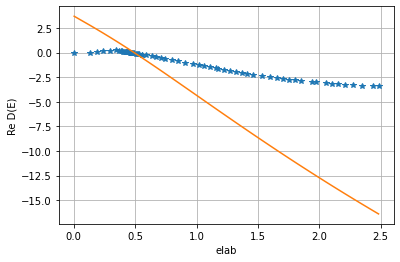

In [145]:
print('fitting with low energy only with 1-para')
para = plot_fit_DL(exp_id=0,L=0, lower_cut=10,upper_cut=40,p0 = (-2) )    

fitting with low energy only with 2-para
Elab_low= 0.40985  Elab_up= 0.79933
[-0.63711434  0.00767774]
para[0] = -6.371143e-01 +/- 3.655456e-03
para[1] = 7.677744e-03 +/- 8.978259e-06
*--mass scale--- for L=0*
scale[0]= 0.637114
scale[1]= 130.246601


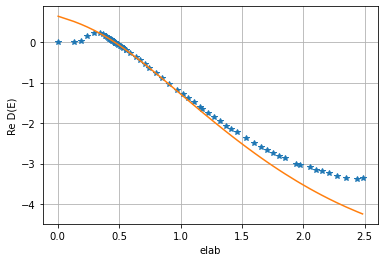

In [146]:
print('fitting with low energy only with 2-para')
para=plot_fit_DL(exp_id=0,L=0, lower_cut=10,upper_cut=40,p0 = (-2,1) ) 

p_para0_low2 = para

fitting with low energy only with 3-para
Elab_low= 0.40985  Elab_up= 0.79933
[-7.13090775e-01  7.32702744e-03 -3.90472555e-07]
para[0] = -7.130908e-01 +/- 1.935544e-02
para[1] = 7.327027e-03 +/- 8.859608e-05
para[2] = -3.904726e-07 +/- 9.830704e-08
*--mass scale--- for L=0*
scale[0]= 0.713091
scale[1]= 136.480996
scale[2]= 136.815876


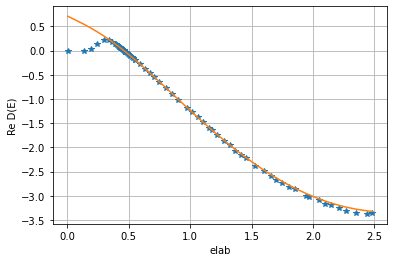

In [147]:
print('fitting with low energy only with 3-para')
para=plot_fit_DL(exp_id=0,L=0, lower_cut=10,upper_cut=40,p0 = (-2,1,1) ) 

Above results implies that fit requires more than one parameter

fitting with whole energy range with 2-para
Elab_low= 0.40985  Elab_up= 1.94257
[-0.51897156  0.00794718]
para[0] = -5.189716e-01 +/- 1.067517e-02
para[1] = 7.947177e-03 +/- 1.387393e-05
*--mass scale--- for L=0*
scale[0]= 0.518972
scale[1]= 125.830843


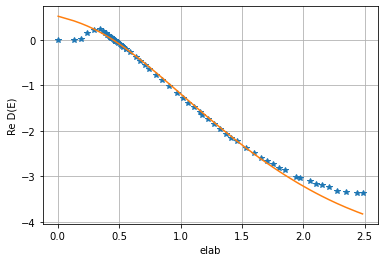

In [148]:
print('fitting with whole energy range with 2-para')
p_para0_2 = plot_fit_DL(exp_id=0,L=0, lower_cut=10,upper_cut=-10,p0 = (-2,1) ) 

fitting with whole energy range with 3-para
Elab_low= 0.40985  Elab_up= 1.94257
[-7.01535264e-01  7.37303818e-03 -3.48431369e-07]
para[0] = -7.015353e-01 +/- 4.262570e-03
para[1] = 7.373038e-03 +/- 1.258419e-05
para[2] = -3.484314e-07 +/- 7.530331e-09
*--mass scale--- for L=0*
scale[0]= 0.701535
scale[1]= 135.629299
scale[2]= 142.110964


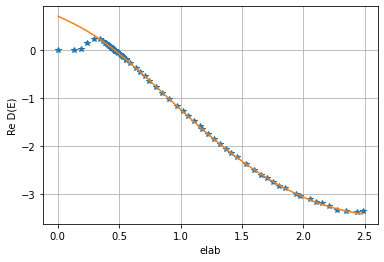

In [150]:
print('fitting with whole energy range with 3-para')
p_para0_3 = plot_fit_DL(exp_id=0,L=0, lower_cut=10,upper_cut=-10,p0 = (-2,1,1) ) 

fitting with whole energy range with 4-para
Elab_low= 0.40985  Elab_up= 1.94257
[-7.08159429e-01  7.34334435e-03 -3.86403665e-07 -1.81138028e-12]
para[0] = -7.081594e-01 +/- 1.319746e-02
para[1] = 7.343344e-03 +/- 5.735895e-05
para[2] = -3.864037e-07 +/- 7.193742e-08
para[3] = -1.811380e-12 +/- 3.412474e-12
*--mass scale--- for L=0*
scale[0]= 0.708159
scale[1]= 136.177735
scale[2]= 137.294431
scale[3]= 223.047866


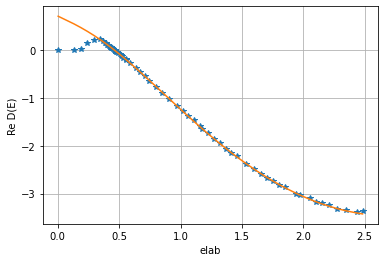

In [152]:
print('fitting with whole energy range with 4-para')
p_para = plot_fit_DL(exp_id=0,L=0, lower_cut=10,upper_cut=-10,p0 = (-2,1,1,1) ) 

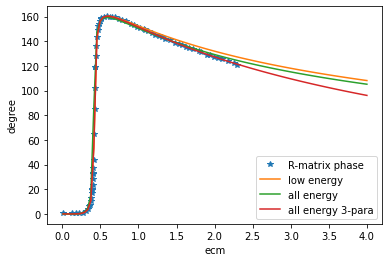

In [153]:
#======================================
ecm = np.linspace(0.01,4.0,100)
kcm = np.sqrt(2*reduced_mass*ecm)

phase0, f_0 = phase_shift_L(0,ecm,reduced_mass=reduced_mass,ERE_para=(*p_para0_low2,0,0) , k_C = k_C, f_L=None )
phase1, f_1 = phase_shift_L(0,ecm,reduced_mass=reduced_mass,ERE_para=(*p_para0_2,0,0), k_C = k_C, f_L=None )
phase2, f_2 = phase_shift_L(0,ecm,reduced_mass=reduced_mass,ERE_para=(*p_para0_3,0), k_C = k_C, f_L=None )

phase0=np.real(phase0)*180/np.pi 
phase0= positive_phase(phase0)

phase1=np.real(phase1)*180/np.pi 
phase1= positive_phase(phase1)

phase2=np.real(phase2)*180/np.pi 
phase2= positive_phase(phase2)

plt.figure()
plt.plot(PhaseShift[0][:,0]*12./13, PhaseShift[0][:,1],'*',label='R-matrix phase' )
plt.plot(ecm,phase0,label='low energy')
plt.plot(ecm,phase1,label='all energy')
plt.plot(ecm,phase2,label='all energy 3-para')
plt.legend()
plt.xlabel('ecm'); plt.ylabel('degree');

#----save fitting result-----
final_para_0 = p_para0_3

One may try to find the resonance position by the $D_l(E)=0$ in complex Energy. 

Near resonance 
$$S(E)\propto \frac{(E-E_R)-i\Gamma}{(E-E_R)+i\Gamma}$$,
$Re D_L(E=E_R)=0$, $Im D_L(E=E_R)\neq 0$. But, $D_L(E=E_R-i\Gamma)=0$.

### Fitted parameter analysis for S1/2

Roughly Fitted parameter values
[1/a, r, P ](in MeV power)=  [-7.10977543e-01  7.34481090e-03 -3.64735987e-07]

imply momentum scale 
mass scales = 0.7109775429055584 272.3010880645741 222.1742854685934

Meaning, S-wave momentum scales as M_{lo}, M_{hi}^{-1}, M_{hi}^{-3}. 
Thus, unnatural power counting seems to be appropriate. 

## P1/2

Elab_low= 1.13333  Elab_up= 2.45663
[ 7.04763975e+03 -7.02187977e+01 -2.36711806e-02]
para[0] = 7.047640e+03 +/- 6.892715e+03
para[1] = -7.021880e+01 +/- 1.006187e+01
para[2] = -2.367118e-02 +/- 3.542087e-03
*--mass scale--- for L=1*
scale[0]= 19.172610
scale[1]= 70.218798
scale[2]= 42.245464


C:\Users\user\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


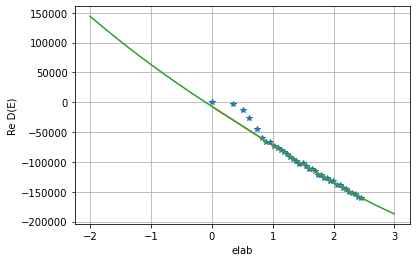

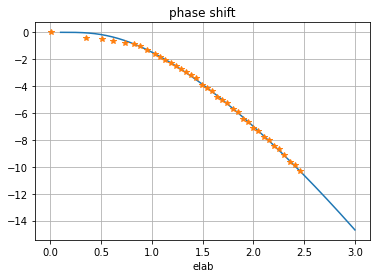

In [159]:
def plot_fit_DL1(exp_id=1,L=1, lower_cut=10,upper_cut=None,p0 = None):
    print('Elab_low=',elab_exp[exp_id][lower_cut],' Elab_up=',elab_exp[exp_id][upper_cut])
    p_para0, pcov0 = scipy.optimize.curve_fit(fit_DL1, ecm_exp[exp_id][lower_cut:upper_cut], ydata[exp_id][lower_cut:upper_cut],p0= p0 )
    print(p_para0)
    print_fit_summary(p_para0,pcov0,L=L)
    yfit = fit_DL(ecm_exp[exp_id],*p_para0,L=L)
    plt.figure()
    plt.plot(elab_exp[exp_id],ydata[exp_id],'*')
    plt.plot(elab_exp[exp_id],yfit);#plt.xlim([0.4,0.5]);plt.ylim([-0.1,0.1]);
    plt.xlabel('elab');plt.ylabel('Re D(E)');
    plt.grid();
    return  p_para0

#----fit
p_para = plot_fit_DL1(exp_id=1,L=1, lower_cut=10,upper_cut=-1,p0 = (-2,1,1) ) # 3-parameter fit 

#--test for negative energy
elab = np.linspace(-2,3,200)
ecm  = elab*reduced_mass/mass_p
yfit = fit_DL1(ecm,*p_para)
plt.plot(elab,yfit)


#phase shift plot
plt.figure()
plt.title('phase shift')
plt.xlabel('elab')
elab = np.linspace(0.1,3,200)
ecm  = elab*reduced_mass/mass_p
phase1, f_1 = phase_shift_L(1,ecm,reduced_mass=reduced_mass,ERE_para=(*p_para,0) , k_C = k_C, f_L=None )
plt.plot(elab,phase1*180/np.pi)
plt.plot(PhaseShift[1][:,0],PhaseShift[1][:,1],'*')
plt.grid()

### What if we use the g.s. binding energy information.. 

It is known that there is a pole of S-matrix at 
$k = i \gamma_B$ with $\gamma_B= 58.00548833081094$ MeV . 

__Be careful that bound state is not at S1/2, but P1/2__


Then, let us define a denominator $D_l(E_{cm})$ as a function of Energy.
It can be written in two forms, 

(1) In terms of phase shifts. 
$$ D_l(E) = k^{2l+1} C_l(\eta)^2 (\cot\delta_L-i) $$ 

(2) In terms of ERE parameters.
$$ D_l(E) = -\frac{1}{a}+\frac{1}{2}r k^2-\frac{1}{4} p k^4 -2 k_C h_l(\eta) $$ 

Let us only consider real part of $D_l(E)$. 
The (1) can be used if phase shifts are known. 
The second form can be used for any energy if we allow complex $k=\sqrt{2\mu E}$.
We know it should be zero at the bound state energy  $D_l(E=-BE)=0$.(Also at resonnance.) 
Eliminating $1/a$ from this condition, one gets 

$$ D_l(E) = \frac{1}{2}r(k^2 +\gamma_B^2)-\frac{1}{4} p(k^4-(i\gamma_B)^4)+2 k_C h_l(\eta=\frac{k_C}{i\gamma_B})-2 k_C h_l(\eta)$$


In [160]:
# P1/2 bound state momentum 
BE=1.9435;
gamma_B = np.sqrt(2*reduced_mass*BE)

def fit_function(Ecm,p1=0.0,p2=0.0,p3=0.0,L=1):
    """
    in case of using binding energy to fix -p0= -1/a
    """
    kcm = np.sqrt(2*reduced_mass*Ecm*(1.0+0j))
    eta = k_C/kcm ;
    sigma = Coulomb_phaseshift(L,eta)
    hL_eta= Coulomb_h_l(L,eta,kcm)
    k_B = 1j*gamma_B
    # compute p0=1/a from bound state pole  
    p0 = -0.5*p1*gamma_B**2-0.25*p2*gamma_B**4-2*k_C*Coulomb_h_l(L,k_C/k_B ,k_B)
    temp = -p0+0.5*p1*kcm**2-0.25*p2*kcm**4+p3*kcm**6 -2*k_C*hL_eta
    return np.real( temp )

def kcot_L(Ecm,delta,L=1,k_C=k_C):
    """
    out = k^{2l+1}C_l(eta)^2 (cot delta_l -i)+2 k_c h_l(eta)
        = -1/a+r/2*k^2-P/4*k^4+...
    """
    kcm = np.sqrt(2*reduced_mass*Ecm*(1.0+0j))
    eta = k_C/kcm ;
    sigma = Coulomb_phaseshift(L,eta)
    hL_eta= Coulomb_h_l(L,eta,kcm)
    temp = kcm**(2*L+1)*Coulomb_factor(L,eta)
    return np.real(temp*(1.0/np.tan(delta)-1j) ) 

# obtain 1/a from r, P, gamma_B 

def get_1overa(gamma_B,r=0,P=0,L=1):
    """
    -p0 = -1/a = 0.5*r*gamma_B**2+0.25*P*gamma_B**4+2*k_C*h_l(1j*gamma_B)
    """
    k_B=1j*gamma_B
    eta_B=k_C/k_B
    temp = 0.5*r*gamma_B**2+0.25*P*gamma_B**4+2*k_C*Coulomb_h_l(L,eta_B,k_B)
    return np.real(temp)


[-2.44906796e+01 -6.53027073e-03]
para[0] = -2.449068e+01 +/- 1.982126e-01
para[1] = -6.530271e-03 +/- 4.396204e-04
*--mass scale--- for L=0*
scale[0]= 24.490680
scale[1]= 153.133008
deduced p0= -35017.79785807329


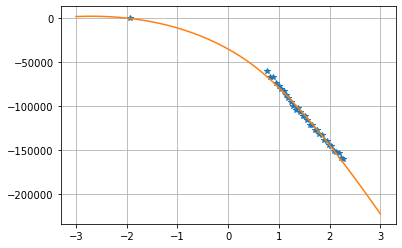

In [163]:
#--phase shift in P1/2 channel 
x = PhaseShift[1][5:,0]*12./13  # Ecm  
y = kcot_L(x,PhaseShift[1][5:,1]*np.pi/180,L=1)

x = [-BE]+list(x); x = np.array(x)
y = [0.0]+list(y); y = np.array(y)

plt.plot(x,y,'*')

p_para, pcov = scipy.optimize.curve_fit(fit_function, x, y,p0= (1.0,1.0))
print(p_para)
print_fit_summary(p_para,pcov,L=0)
print('deduced p0=',get_1overa(gamma_B,*p_para,L=1) )

Ecms = np.linspace(-3.0,3.0,200 )
yfit=fit_function(Ecms,*p_para)
plt.plot(Ecms,yfit);#plt.xlim([-3,2]);plt.ylim([-20,2]);
plt.grid();

In [164]:
# In above case, mass scale correspondence 

print('p0**(1./3.)=',np.abs(get_1overa(gamma_B,*p_para,L=1))**(1./3.),
      ' p1 =', np.abs(p_para[0]),
      ' p2**(-1) =', np.abs(p_para[1])**(-1))

final_para_1_1 = np.array([-35017.79785807329] +list(p_para))

p0**(1./3.)= 32.71620673127435  p1 = 24.490679551460303  p2**(-1) = 153.13300792792344


## P3/2

Elab_low= 1.33158  Elab_up= 2.45952
[-4.38201694e+05 -2.75269240e+02]
para[0] = -4.382017e+05 +/- 1.946010e+04
para[1] = -2.752692e+02 +/- 1.358986e+01
*--mass scale--- for L=1*
scale[0]= 75.955288
scale[1]= 275.269240
Elab_low= 1.33158  Elab_up= 2.45952
[-1.21165268e+06 -1.32337891e+03 -3.47712717e-01]
para[0] = -1.211653e+06 +/- 3.984724e+04
para[1] = -1.323379e+03 +/- 5.351032e+01
para[2] = -3.477127e-01 +/- 1.769338e-02
*--mass scale--- for L=1*
scale[0]= 106.608717
scale[1]= 1323.378914
scale[2]= 2.875937
Elab_low= 1.33158  Elab_up= 2.45952
[-2.49179220e+06 -4.01506668e+03 -2.20447346e+00 -5.24615666e-05]
para[0] = -2.491792e+06 +/- 1.283233e+05
para[1] = -4.015067e+03 +/- 2.675167e+02
para[2] = -2.204473e+00 +/- 1.836881e-01
para[3] = -5.246157e-05 +/- 5.182816e-06
*--mass scale--- for L=1*
scale[0]= 135.572189
scale[1]= 4015.066684
scale[2]= 0.453623
scale[3]= 26.712810


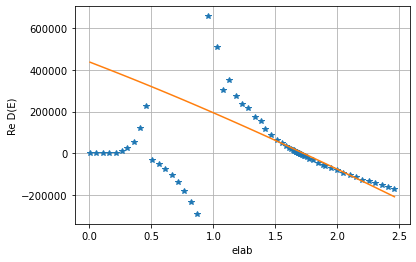

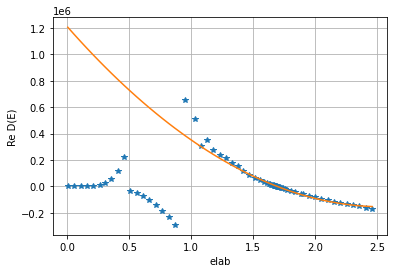

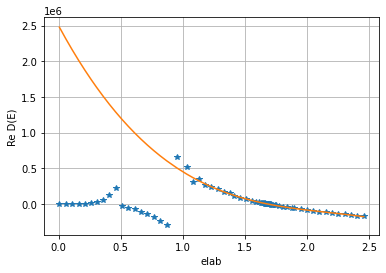

In [186]:
def plot_fit_DL1(exp_id=2,L=1, lower_cut=20,upper_cut=None,p0 = None):
    print('Elab_low=',elab_exp[exp_id][lower_cut],' Elab_up=',elab_exp[exp_id][upper_cut])
    p_para0, pcov0 = scipy.optimize.curve_fit(fit_DL1, ecm_exp[exp_id][lower_cut:upper_cut], ydata[exp_id][lower_cut:upper_cut],p0= p0 )
    print(p_para0)
    print_fit_summary(p_para0,pcov0,L=L)
    yfit = fit_DL(ecm_exp[exp_id],*p_para0,L=L)
    plt.figure()
    plt.plot(elab_exp[exp_id],ydata[exp_id],'*')
    plt.plot(elab_exp[exp_id],yfit);#plt.xlim([0.4,0.5]);plt.ylim([-0.1,0.1]);
    plt.xlabel('elab');plt.ylabel('Re D(E)');
    plt.grid();
    return  p_para0
#----fit
p_para_2 = plot_fit_DL1(exp_id=2,L=1, lower_cut=25,upper_cut=-1,p0 = (-2,1) ) 

p_para_3 = plot_fit_DL1(exp_id=2,L=1, lower_cut=25,upper_cut=-1,p0 = (-2,1,1) ) # 3-parameter fit 

p_para_4 = plot_fit_DL1(exp_id=2,L=1, lower_cut=25,upper_cut=-1,p0 = (-2,1,1,1) ) # 3-parameter fit 

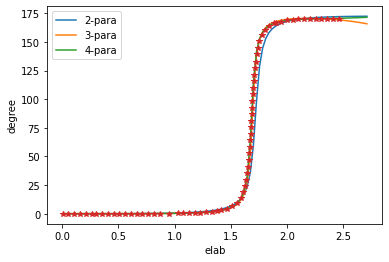

In [188]:
#========Phase Shift plot==
ecm = np.linspace(0.01,2.5,100)
kcm = np.sqrt(2*reduced_mass*ecm)
elab = ecm*mass_p/reduced_mass

phase2, f_0 = phase_shift_L(1,ecm,reduced_mass=reduced_mass,ERE_para=(*p_para_2,0,0) , k_C = k_C, f_L=None )
phase3, f_0 = phase_shift_L(1,ecm,reduced_mass=reduced_mass,ERE_para=(*p_para_3,0) , k_C = k_C, f_L=None )
phase4, f_0 = phase_shift_L(1,ecm,reduced_mass=reduced_mass,ERE_para=(*p_para_4,) , k_C = k_C, f_L=None )

phase2=np.real(phase2)*180/np.pi 
phase2= positive_phase(phase2)
phase3=np.real(phase3)*180/np.pi 
phase3= positive_phase(phase3)
phase4=np.real(phase4)*180/np.pi 
phase4= positive_phase(phase4)

plt.figure()
plt.plot(elab,phase2,label='2-para')
plt.plot(elab,phase3,label='3-para')
plt.plot(elab,phase4,label='4-para')
plt.plot(PhaseShift[2][:,0],PhaseShift[2][:,1],'*')
plt.legend()
plt.xlabel('elab'); plt.ylabel('degree');

#----save fitting result-----
final_para_0 = p_para0_3

## P3/2 case direct fit to phase shift

[-57856.52755093]
para[0] = -5.785653e+04 +/- 9.081977e+02
p0**(1/3.)= 38.676822572374604


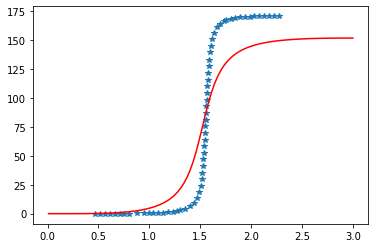

In [31]:
def fit_function(ecm,p0=0.0,p1=0.0,p2=0.0,p3=0.0,L=1):
    delta_L, f_L = phase_shift_L(L,ecm,reduced_mass=reduced_mass,ERE_para=(p0,p1,p2,p3), k_C = k_C, f_L=None )
    delta_L = np.real(delta_L)
    delta_L = (delta_L >=0)*delta_L +(delta_L<-0)*(delta_L+np.pi)
    return delta_L*180/np.pi 

xdata = PhaseShift[2][10:,0]*12./13  # ecm  
ydata = PhaseShift[2][10:,1]

p0=[6.18990702e+04]
p_para, pcov = scipy.optimize.curve_fit(fit_function, xdata, ydata,p0= p0)
print(p_para)
print_fit_summary(p_para,pcov)
yfit=fit_function(ecm,*p_para)

plt.plot(xdata,ydata,'*')
plt.plot(ecm,yfit,'r')

#----save fitting result-----
#final_para_1_2 = p_para;

print('p0**(1/3.)=',np.abs(p_para[0])**(1./3.),
     )

[-4.89081818e+05 -3.19825722e+02]
para[0] = -4.890818e+05 +/- 5.573904e+03
para[1] = -3.198257e+02 +/- 4.133306e+00
p0**(1/3.)= 78.78807796374895  p1 = 319.8257221863781


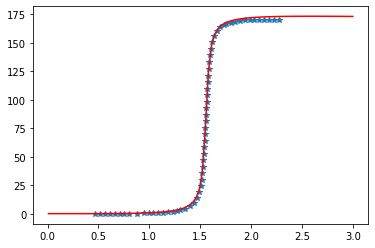

In [79]:
def fit_function(ecm,p0=0.0,p1=0.0,p2=0.0,p3=0.0,L=1):
    delta_L, f_L = phase_shift_L(L,ecm,reduced_mass=reduced_mass,ERE_para=(p0,p1,p2,p3), k_C = k_C, f_L=None )
    delta_L = np.real(delta_L)
    delta_L = (delta_L >=0)*delta_L +(delta_L<-0)*(delta_L+np.pi)
    return delta_L*180/np.pi 

xdata = PhaseShift[2][10:,0]*12./13  # ecm  
ydata = PhaseShift[2][10:,1]

p0=[6.18990702e+04, 4.22741642e+02]
p_para, pcov = scipy.optimize.curve_fit(fit_function, xdata, ydata,p0= p0)
print(p_para)
print_fit_summary(p_para,pcov)
yfit=fit_function(ecm,*p_para)

plt.plot(xdata,ydata,'*')
plt.plot(ecm,yfit,'r')

#----save fitting result-----
final_para_1_2 = p_para;

print('p0**(1/3.)=',np.abs(p_para[0])**(1./3.),
      ' p1 =', np.abs(p_para[1])
     )

[-9.21440835e+05 -9.54244131e+02 -2.32668152e-01]
para[0] = -9.214408e+05 +/- 2.266973e+04
para[1] = -9.542441e+02 +/- 3.277030e+01
para[2] = -2.326682e-01 +/- 1.186746e-02
p0**(1/3.)= 97.30962934591481  p1 = 954.2441308612388  p2**(-1) = 4.297966838207406


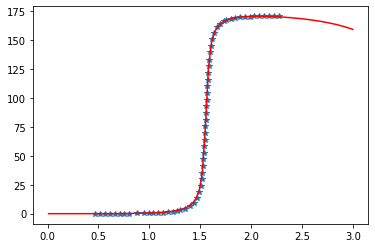

In [113]:
xdata = PhaseShift[2][10:,0]*12./13  # ecm  
ydata = PhaseShift[2][10:,1]
p0=[6.18990702e+04, 4.22741642e+02, 2.33090070e-01]
p_para, pcov = scipy.optimize.curve_fit(fit_function, xdata, ydata,p0= p0)
print(p_para)
print_fit_summary(p_para,pcov)
yfit=fit_function(ecm,*p_para)

plt.plot(xdata,ydata,'*')
plt.plot(ecm,yfit,'r')

#----save fitting result-----
#final_para_1_2 = p_para;

print('p0**(1/3.)=',np.abs(p_para[0])**(1./3.),
      ' p1 =', np.abs(p_para[1]),
      ' p2**(-1) =', np.abs(p_para[2])**(-1)
     )

[-1.55268810e+06 -2.23857859e+03 -1.09633277e+00 -2.39518952e-05]
para[0] = -1.552688e+06 +/- 2.131460e+05
para[1] = -2.238579e+03 +/- 4.331534e+02
para[2] = -1.096333e+00 +/- 2.911988e-01
para[3] = -2.395190e-05 +/- 8.084724e-06
p0**(1/3.)= 115.79631571158002  p1 = 2238.5785932793992  p2**(-1) = 0.9121318180345404  p3**(-3) = 0.7588794921209727


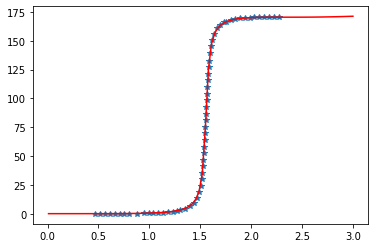

In [95]:
def phase_shift_L_test(L,ecm,reduced_mass=reduced_mass,ERE_para=(0.0,0.0,0.0,0.0), k_C = k_C, f_L=None ):
    """
    return value in radian 
    
    ERE_para = (1/a, r, P)
    """
    kcm = np.sqrt(2*reduced_mass*ecm)
    if f_L :
        temp = 1+2*1j*kcm*f_L
    else :
        eta = k_C/kcm ;
        sigma = Coulomb_phaseshift(L,eta)
        hL_eta= Coulomb_h_l(L,eta,kcm)
        Cfactor= kcm**(2*L)*Coulomb_factor(L,eta)
        para = ERE_para ; # pass ERE parameters
        f_L = Cfactor/(-para[0]+0.5*para[1]*kcm**2-para[2]/4*kcm**4+para[3]*kcm**6-2*k_C*hL_eta)
        temp = 1+2*1j*kcm*f_L        
    delta_L = np.log(temp)/(2*1j)
    return delta_L, f_L 

def fit_function(ecm,p0=0.0,p1=0.0,p2=0.0,p3=0.0,p4=0.0,L=1):
    delta_L, f_L = phase_shift_L_test(L,ecm,reduced_mass=reduced_mass,ERE_para=(p0,p1,p2,p3,p4), k_C = k_C, f_L=None )
    delta_L = np.real(delta_L)
    delta_L = (delta_L >=0)*delta_L +(delta_L<-0)*(delta_L+np.pi)
    return delta_L*180/np.pi 

xdata = PhaseShift[2][10:,0]*12./13  # ecm  
ydata = PhaseShift[2][10:,1]
p0=[6.18990702e+04, 4.22741642e+02, 2.33090070e-01,1e-3]
p_para, pcov = scipy.optimize.curve_fit(fit_function, xdata, ydata,p0= p0)
print(p_para)
print_fit_summary(p_para,pcov)
yfit=fit_function(ecm,*p_para)

plt.plot(xdata,ydata,'*')
plt.plot(ecm,yfit,'r')

#----save fitting result-----
#final_para_1_2 = p_para;

print('p0**(1/3.)=',np.abs(p_para[0])**(1./3.),
      ' p1 =', np.abs(p_para[1]),
      ' p2**(-1) =', np.abs(p_para[2])**(-1),
      ' p3**(-3) =', np.abs(p_para[2])**(-3)
     )

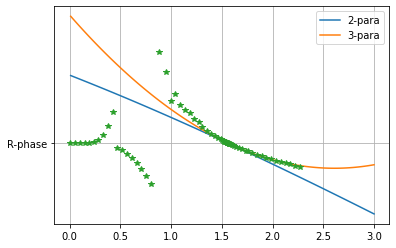

In [114]:
yfit = fit_DL1(ecm,*final_para_1_2)
plt.plot(ecm,yfit,label='2-para');

yfit = fit_DL1(ecm,*p_para)
plt.plot(ecm,yfit,label='3-para');plt.grid();

def kcot_L(Ecm,delta,L=1,k_C=k_C):
    kcm = np.sqrt(2*reduced_mass*Ecm*(1.0+0j))
    eta = k_C/kcm ;
    sigma = Coulomb_phaseshift(L,eta)
    hL_eta= Coulomb_h_l(L,eta,kcm)
    temp = kcm**(2*L+1)*Coulomb_factor(L,eta)
    return np.real(temp*(1.0/np.tan(delta)-1j) ) 
ecm_exp = PhaseShift[2][:,0]*12./13
ydata = kcot_L(ecm_exp, PhaseShift[2][:,1]*np.pi/180,L=1)
plt.plot(ecm_exp,ydata,'*','R-phase' )

plt.legend()


## D5/2

Elab_low= 1.7256  Elab_up= 2.4593
[-8.57589058e+09 -5.62571106e+06]
para[0] = -8.575891e+09 +/- 3.194379e+07
para[1] = -5.625711e+06 +/- 2.083172e+04
*--mass scale--- for L=2*
scale[0]= 96.974120
scale[1]= 177.852159
Elab_low= 1.7256  Elab_up= 2.4593
[-7.00276516e+09 -3.65089405e+06  6.11231430e+02]
para[0] = -7.002765e+09 +/- 2.868826e+08
para[1] = -3.650894e+06 +/- 3.593246e+05
para[2] = 6.112314e+02 +/- 1.111225e+02
*--mass scale--- for L=2*
scale[0]= 93.122347
scale[1]= 153.980743
scale[2]= 611.231430


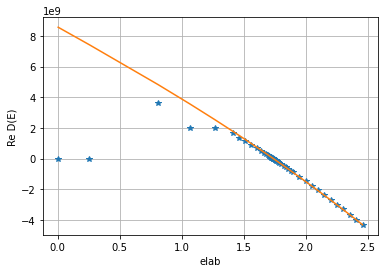

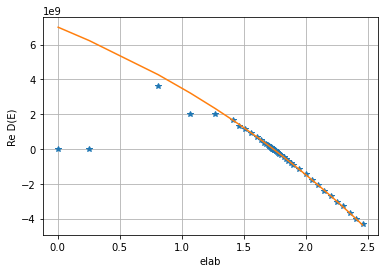

In [191]:
def plot_fit_DL2(exp_id=3,L=2, lower_cut=20,upper_cut=None,p0 = None):
    print('Elab_low=',elab_exp[exp_id][lower_cut],' Elab_up=',elab_exp[exp_id][upper_cut])
    p_para0, pcov0 = scipy.optimize.curve_fit(fit_DL2, ecm_exp[exp_id][lower_cut:upper_cut], ydata[exp_id][lower_cut:upper_cut],p0= p0 )
    print(p_para0)
    print_fit_summary(p_para0,pcov0,L=L)
    yfit = fit_DL2(ecm_exp[exp_id],*p_para0,L=L)
    plt.figure()
    plt.plot(elab_exp[exp_id],ydata[exp_id],'*')
    plt.plot(elab_exp[exp_id],yfit);#plt.xlim([0.4,0.5]);plt.ylim([-0.1,0.1]);
    plt.xlabel('elab');plt.ylabel('Re D(E)');
    plt.grid();
    return  p_para0
#----fit
p_para_2 = plot_fit_DL2(exp_id=3,L=2, lower_cut=20,upper_cut=-1,p0 = (-2,1) ) 

p_para_3 = plot_fit_DL2(exp_id=3,L=2, lower_cut=20,upper_cut=-1,p0 = (-2,1,1) ) # 3-parameter fit 
